# MTA Bus Performance & Violations Analysis Summary

This notebook analyzes MTA bus route performance and automated camera enforcement (ACE) violations in NYC. Key steps include data cleaning, aggregation, and visualization. 

**Main Insights:**
- Top and bottom bus routes by average road speed, highlighting borough differences.
- Impact of ACE: routes with violations vs. those without.
- Geospatial and temporal trends in bus performance.
- Borough-level comparisons for high-performing routes.

Each section below presents essential code and visualizations supporting these findings.

In [3]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Read datasets
violations = pd.read_csv('MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250917.csv')
speed = pd.read_csv('/Users/Marcy_Student/Desktop/marcy/Datathon/MTA_Bus_Route_Segment_Speeds__2023_-_2024_20250923.csv')

## EDA- Exploratory Data Analysis And Data Cleaning

In [5]:
# Count missing values in each column of violations DataFrame
missing_values = violations.isnull().sum()
total_missing = violations.isnull().sum().sum()
print('Missing values per column in violations:')
print(missing_values)
print(f'Total missing values in violations: {total_missing}')

# Count missing values in each column of speed DataFrame
missing_values_speed = speed.isnull().sum()
total_missing_speed = speed.isnull().sum().sum()
print('Missing values per column in speed:')
print(missing_values_speed)


Missing values per column in violations:
Violation ID                  0
Vehicle ID                66366
First Occurrence              0
Last Occurrence               0
Violation Status              0
Violation Type                0
Bus Route ID              10749
Violation Latitude            0
Violation Longitude           0
Stop ID                       0
Stop Name                     0
Bus Stop Latitude             0
Bus Stop Longitude            0
Violation Georeference        0
Bus Stop Georeference         0
dtype: int64
Total missing values in violations: 77115
Missing values per column in speed:
Year                                   0
Month                                  0
Timestamp                              0
Day of Week                            0
Hour of Day                            0
Route ID                               0
Direction                              0
Borough                                0
Route Type                             0
Stop Order         

In [6]:
# columns names overview
violations.columns
speed.columns

Index(['Year', 'Month', 'Timestamp', 'Day of Week', 'Hour of Day', 'Route ID',
       'Direction', 'Borough', 'Route Type', 'Stop Order', 'Timepoint Stop ID',
       'Timepoint Stop Name', 'Timepoint Stop Latitude',
       'Timepoint Stop Longitude', 'Next Timepoint Stop ID',
       'Next Timepoint Stop Name', 'Next Timepoint Stop Latitude',
       'Next Timepoint Stop Longitude', 'Road Distance', 'Average Travel Time',
       'Average Road Speed', 'Bus Trip Count', 'Timepoint Stop Georeference',
       'Next Timepoint Stop Georeference'],
      dtype='object')

In [7]:
# Show unique values and counts for bus route id in violations DataFrame
if 'Bus Route ID' in violations.columns:
    route_counts = violations['Bus Route ID'].value_counts(dropna=False)
    print('Unique values and counts for Bus Route ID:')
    print(route_counts)
else:
    print('Column "Bus Route Id" not found in violations DataFrame.')

Unique values and counts for Bus Route ID:
Bus Route ID
M15+         502765
BX19         344147
M101         312466
BX41+        229920
BX36         225835
B46+         186192
BX12+        185059
B44+         171083
Q44+         164806
BX6+         111403
B35          106526
B82+         106426
M60+         100427
Q58           97785
B41           94151
Q54           88424
BX35          77259
M14+          63941
BX28          61812
Q43           60123
B25           44304
M100          43182
S46           41603
M86+          40498
M79+          37788
Q53+          36728
Q5            31230
BX38          29878
B62           26612
M34+          23958
M2            23884
S79+          21337
B26           20656
M23+          16406
M4            13031
NaN           10749
B42           10600
Q69            5794
M42            5729
BX28-BX38      2675
BX5            1376
Name: count, dtype: int64


In [8]:
# Filter violations for Bus Route IDs present from 2019 to 2025
violations['Year'] = pd.to_datetime(violations['Last Occurrence'], errors='coerce').dt.year
bus_route_years = violations.groupby('Bus Route ID')['Year'].agg(['min', 'max'])
valid_routes = bus_route_years[(bus_route_years['min'] <= 2019) & (bus_route_years['max'] >= 2025)].index
filtered_violations = violations[violations['Bus Route ID'].isin(valid_routes)]
filtered_violations['Bus Route ID'].nunique()

## in 2019, only 4 buses were implemented with ACE

/var/folders/bs/gtwb0lj97nb4v95968dmfzww0000gp/T/ipykernel_34100/185894737.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  violations['Year'] = pd.to_datetime(violations['Last Occurrence'], errors='coerce').dt.year


4

In [9]:
speed.columns
# Create a new column in speed: Route ID with + if Route Type is not 'local'
speed['Route ID Modified'] = speed.apply(lambda row: str(row['Route ID']) + '+' if str(row['Route Type']).lower() != 'local' else row['Route ID'], axis=1)
speed[['Route ID', 'Route Type', 'Route ID Modified']].head()

,Route ID,Route Type,Route ID Modified
0,B6,Limited,B6+
1,B6,Limited,B6+
2,BX42,Local,BX42
3,BXM1,Express,BXM1+
4,BXM1,Express,BXM1+


In [10]:
# Group speed by Route ID Modified, year, month, direction, borough and aggregate averages
speed['Year'] = pd.to_datetime(speed['Timestamp'], errors='coerce').dt.year
speed['Month'] = pd.to_datetime(speed['Timestamp'], errors='coerce').dt.month
grouped_speed = speed.groupby(['Route ID Modified', 'Year', 'Month', 'Direction', 'Borough'], dropna=False).agg({
    'Average Road Speed': 'mean',
    'Average Travel Time': 'mean'
}).reset_index()
grouped_speed.head()

,Route ID Modified,Year,Month,Direction,Borough,Average Road Speed,Average Travel Time
0,B1,2023,1,N,Brooklyn,9.659854,8.935863
1,B1,2023,1,S,Brooklyn,8.195344,10.636164
2,B1,2023,2,N,Brooklyn,9.622038,8.984310
3,B1,2023,2,S,Brooklyn,8.218554,10.667293
4,B1,2023,3,N,Brooklyn,9.765665,8.949245


In [11]:
# Group violations by month of Last Occurrence, Bus Route ID, aggregated by count of Violation ID
violations['Month'] = pd.to_datetime(violations['Last Occurrence'], errors='coerce').dt.month
grouped_violations = violations.groupby(['Month', 'Bus Route ID'], dropna=False)['Violation ID'].count().reset_index()
grouped_violations.rename(columns={'Violation ID': 'Violation Count'}, inplace=True)
print(grouped_violations.head())

/var/folders/bs/gtwb0lj97nb4v95968dmfzww0000gp/T/ipykernel_34100/2731197716.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  violations['Month'] = pd.to_datetime(violations['Last Occurrence'], errors='coerce').dt.month


   Month Bus Route ID  Violation Count
0      1          B25             4970
1      1          B26             2589
2      1          B35             7629
3      1          B41             9707
4      1          B42             1110


In [12]:
# Rename columns to 'Bus_name' for consistency
grouped_violations.rename(columns={'Bus Route ID': 'Bus_name'}, inplace=True)
grouped_speed.rename(columns={'Route ID Modified': 'Bus_name'}, inplace=True)

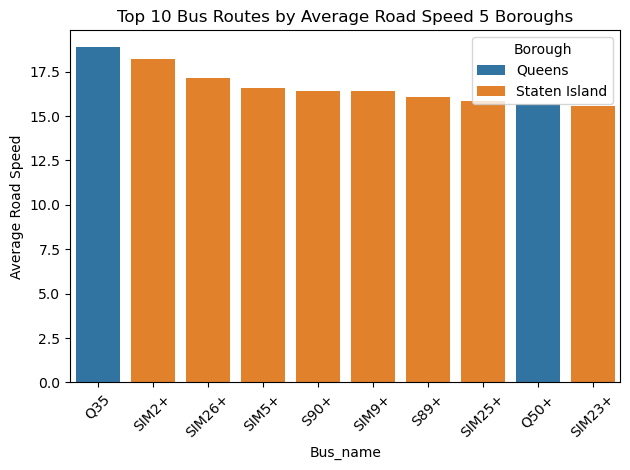

In [14]:
# Barplot of top 10 distinct Bus_name values aggregated by average road speed, only for Manhattan, Brooklyn, Queens, Bronx
big_boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx','Staten Island']
filtered_boroughs = grouped_speed[grouped_speed['Borough'].isin(big_boroughs)]
top10_busnames_boroughs = filtered_boroughs.groupby(['Bus_name', 'Borough'], as_index=False)['Average Road Speed'].mean().nlargest(10, 'Average Road Speed')
sns.barplot(data=top10_busnames_boroughs, x='Bus_name', y='Average Road Speed', hue='Borough')
plt.title('Top 10 Bus Routes by Average Road Speed 5 Boroughs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

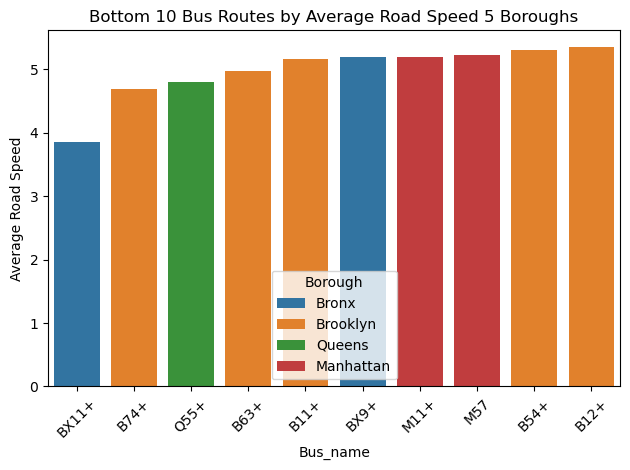

In [15]:
# Barplot of bottom 10 distinct Bus_name values aggregated by average road speed, only for Manhattan, Brooklyn, Queens, Bronx, Staten Island
bottom10_busnames_boroughs = filtered_boroughs.groupby(['Bus_name', 'Borough'], as_index=False)['Average Road Speed'].mean().nsmallest(10, 'Average Road Speed')
sns.barplot(data=bottom10_busnames_boroughs, x='Bus_name', y='Average Road Speed', hue='Borough')
plt.title('Bottom 10 Bus Routes by Average Road Speed 5 Boroughs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# MERGE grouped_violations and speed_violations

Vio_speed = pd.merge(grouped_speed,grouped_violations, how='left', on='Bus_name')
Vio_speed

,Bus_name,Year,Month_x,Direction,Borough,Average Road Speed,Average Travel Time,Month_y,Violation Count
0,B1,2023,1,N,Brooklyn,9.659854,8.935863,NaN,NaN
1,B1,2023,1,S,Brooklyn,8.195344,10.636164,NaN,NaN
2,B1,2023,2,N,Brooklyn,9.622038,8.984310,NaN,NaN
3,B1,2023,2,S,Brooklyn,8.218554,10.667293,NaN,NaN
4,B1,2023,3,N,Brooklyn,9.765665,8.949245,NaN,NaN
...,...,...,...,...,...,...,...,...,...
31079,X68+,2024,10,W,Queens,12.696511,20.344060,NaN,NaN
31080,X68+,2024,11,E,Queens,9.108831,26.485542,NaN,NaN
31081,X68+,2024,11,W,Queens,12.592638,20.559511,NaN,NaN
31082,X68+,2024,12,E,Queens,9.020379,26.612155,NaN,NaN


In [17]:
# Get unique Bus_name values with NaN violation count from Vio_speed and Borough in Manhattan, Brooklyn, Queens
nan_violation_buses = Vio_speed[
	(Vio_speed['Violation Count'].isna()) &
	(Vio_speed['Borough'].isin(['Manhattan', 'Brooklyn', 'Queens','Staten Island','Bronx']) )
]['Bus_name'].unique()
print(len(nan_violation_buses))

violation_buses = Vio_speed[
	(~Vio_speed['Violation Count'].isna())
]['Bus_name'].unique()
print(len(violation_buses))

# 26 buses routes are equiped with ace , from chat gpt source as of today there were 39 , pretty close
# The assumption is if you do not have any violations you are not equipped with ace
len(Vio_speed['Bus_name'].unique())
Rate_buses_with_ace = len(violation_buses)/len(Vio_speed['Bus_name'].unique())
print(f'Rate of buses with ACE: {Rate_buses_with_ace:.2%}')


409
26
Rate of buses with ACE: 5.58%


In [18]:
# Filter Vio_speed to only rows with at least 1 violation count
vio_speed_with_violations = Vio_speed[~Vio_speed['Violation Count'].isna()]
vio_speed_with_violations.head()

,Bus_name,Year,Month_x,Direction,Borough,Average Road Speed,Average Travel Time,Month_y,Violation Count
758,B25,2023,1,E,Brooklyn,7.115964,9.083726,1.0,4970.0
759,B25,2023,1,E,Brooklyn,7.115964,9.083726,2.0,3523.0
760,B25,2023,1,E,Brooklyn,7.115964,9.083726,3.0,4011.0
761,B25,2023,1,E,Brooklyn,7.115964,9.083726,4.0,3443.0
762,B25,2023,1,E,Brooklyn,7.115964,9.083726,5.0,4057.0


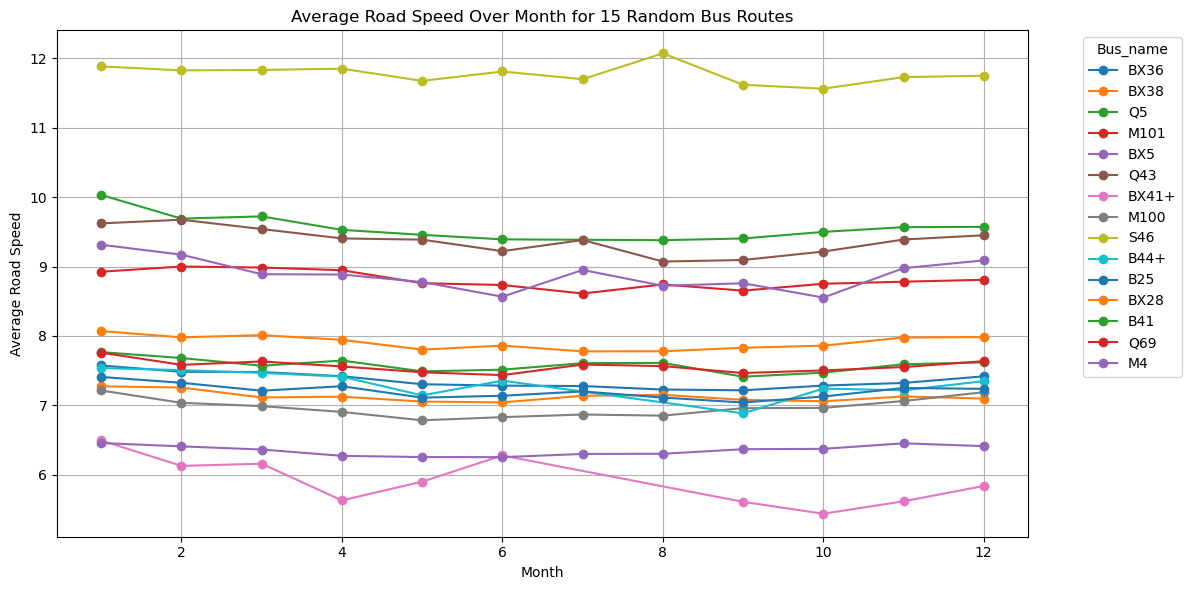

In [19]:
# Random sample of 10 unique bus names and plot their average road speed over month
import random
unique_buses = vio_speed_with_violations['Bus_name'].unique()
sample_buses = random.sample(list(unique_buses), 15)
sample_data = vio_speed_with_violations[vio_speed_with_violations['Bus_name'].isin(sample_buses)]
monthly_avg_speed = sample_data.groupby(['Bus_name', 'Month_x'], as_index=False)['Average Road Speed'].mean()
plt.figure(figsize=(12, 6))
for bus in sample_buses:
    bus_data = monthly_avg_speed[monthly_avg_speed['Bus_name'] == bus]
    plt.plot(bus_data['Month_x'], bus_data['Average Road Speed'], marker='o', label=bus)
plt.title('Average Road Speed Over Month for 15 Random Bus Routes')
plt.xlabel('Month')
plt.ylabel('Average Road Speed')
plt.legend(title='Bus_name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

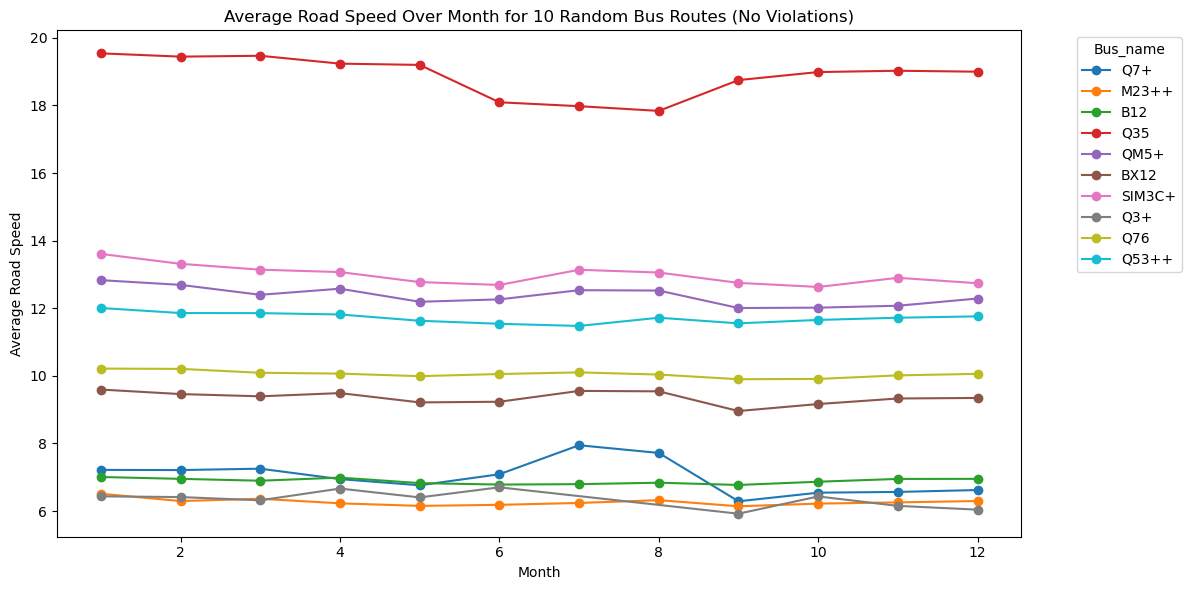

In [20]:
# Random sample of 10 unique bus names from vio_speed_without_violations and plot their average road speed over month
vio_speed_without_violations = Vio_speed[Vio_speed['Violation Count'].isna() | (Vio_speed['Violation Count'] == 0)]
unique_buses_no_vio = vio_speed_without_violations['Bus_name'].unique()
sample_buses_no_vio = random.sample(list(unique_buses_no_vio), 10)
sample_data_no_vio = vio_speed_without_violations[vio_speed_without_violations['Bus_name'].isin(sample_buses_no_vio)]
monthly_avg_speed_no_vio = sample_data_no_vio.groupby(['Bus_name', 'Month_x'], as_index=False)['Average Road Speed'].mean()
plt.figure(figsize=(12, 6))
for bus in sample_buses_no_vio:
    bus_data = monthly_avg_speed_no_vio[monthly_avg_speed_no_vio['Bus_name'] == bus]
    plt.plot(bus_data['Month_x'], bus_data['Average Road Speed'], marker='o', label=bus)
plt.title('Average Road Speed Over Month for 10 Random Bus Routes (No Violations)')
plt.xlabel('Month')
plt.ylabel('Average Road Speed')
plt.legend(title='Bus_name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
vio_speed_with_violations['Bus_name'].unique()

array(['B25', 'B26', 'B35', 'B41', 'B42', 'B44+', 'B46+', 'B62', 'BX19',
       'BX28', 'BX35', 'BX36', 'BX38', 'BX41+', 'BX5', 'M100', 'M101',
       'M2', 'M4', 'M42', 'Q43', 'Q5', 'Q54', 'Q58', 'Q69', 'S46'],
      dtype=object)

In [22]:
# Group grouped_speed by Bus_name, aggregate by mean of Average Road Speed, order descending
bus_avg_speed = grouped_speed.groupby('Bus_name', as_index=False)['Average Road Speed'].mean().sort_values(by='Average Road Speed', ascending=True)
bus_avg_speed.head()

,Bus_name,Average Road Speed
97,BX11+,3.861361
74,B74+,4.683748
316,Q55+,4.800090
62,B63+,4.973795
6,B11+,5.164328


In [23]:
# Group vio_speed_with_violations by Bus_name, Year, Month and aggregate by mean of Average Road Speed and Average Travel Time
vio_speed_grouped = vio_speed_with_violations.groupby(['Bus_name', 'Year', 'Month_x', 'Borough'], as_index=False).agg({
    'Average Road Speed': 'mean',
    'Average Travel Time': 'mean'
})
print(vio_speed_grouped.head())

# Only include Manhattan, Bronx, Brooklyn

selected_boroughs = ['Manhattan', 'Bronx', 'Brooklyn']

vio_speed_grouped_filtered = vio_speed_grouped[vio_speed_grouped['Borough'].isin(selected_boroughs)]

# Find 2 highest, 3 middle, 2 lowest bus_name by average road speed (overall average per bus)

bus_avg_speed = vio_speed_grouped_filtered.groupby('Bus_name', as_index=False)['Average Road Speed'].mean().sort_values(by='Average Road Speed')

# 2 lowest

lowest = bus_avg_speed.head(2)

# 3 middle

middle_idx = len(bus_avg_speed) // 2

middle = bus_avg_speed.iloc[middle_idx-1:middle_idx+2] if len(bus_avg_speed) >= 3 else bus_avg_speed

# 2 highest

highest = bus_avg_speed.tail(2)

print('Lowest 2:')

print(lowest)

print('Middle 3:')

print(middle)

print('Highest 2:')

print(highest)

  Bus_name  Year  Month_x   Borough  Average Road Speed  Average Travel Time
0      B25  2023        1  Brooklyn            7.416946             8.476360
1      B25  2023        2  Brooklyn            7.345396             8.560144
2      B25  2023        3  Brooklyn            7.267225             8.682221
3      B25  2023        4  Brooklyn            7.316048             8.660980
4      B25  2023        5  Brooklyn            7.251781             8.890629
Lowest 2:
   Bus_name  Average Road Speed
19      M42            5.483043
13    BX41+            5.910786
Middle 3:
   Bus_name  Average Road Speed
0       B25            7.203885
5      B44+            7.312350
11     BX36            7.358422
Highest 2:
   Bus_name  Average Road Speed
14      BX5            8.887389
17       M2            9.582634


/var/folders/bs/gtwb0lj97nb4v95968dmfzww0000gp/T/ipykernel_34100/3439691557.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3_per_borough = bus_borough_avg.groupby('Borough').apply(lambda x: x.nlargest(3, 'Average Road Speed')).reset_index(drop=True)


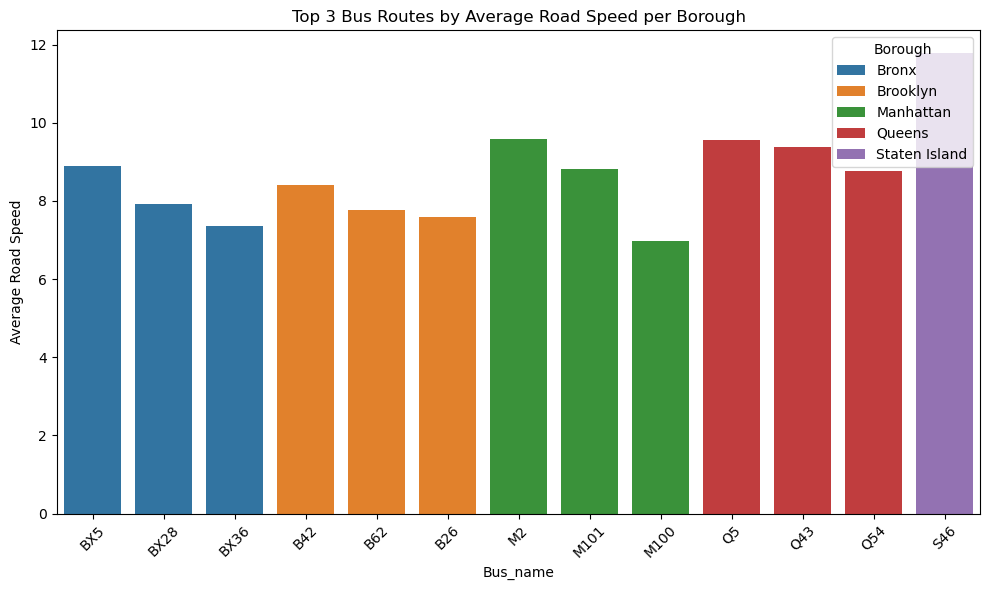

In [24]:
# Barplot of the 3 top high average road speed per borough in vio_speed_with_violations

# Group by Bus_name and Borough, aggregate by mean average road speed
bus_borough_avg = vio_speed_with_violations.groupby(['Bus_name', 'Borough'], as_index=False)['Average Road Speed'].mean()

# For each borough, get top 3 bus routes by average road speed
top3_per_borough = bus_borough_avg.groupby('Borough').apply(lambda x: x.nlargest(3, 'Average Road Speed')).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=top3_per_borough, x='Bus_name', y='Average Road Speed', hue='Borough')
plt.title('Top 3 Bus Routes by Average Road Speed per Borough')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/bs/gtwb0lj97nb4v95968dmfzww0000gp/T/ipykernel_34100/1560019679.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top3_per_borough_no_vio = bus_borough_avg_no_vio.groupby('Borough').apply(lambda x: x.nlargest(3, 'Average Road Speed')).reset_index(drop=True)


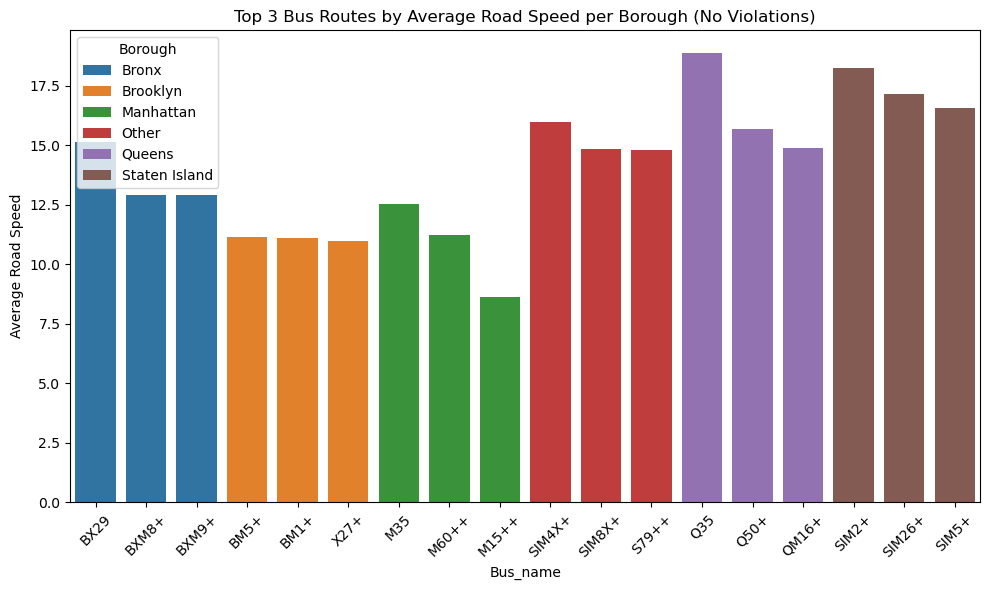

In [25]:
# Barplot of the 3 top high average road speed per borough in vio_speed_without_violations
# Group by Bus_name and Borough, aggregate by mean average road speed
bus_borough_avg_no_vio = vio_speed_without_violations.groupby(['Bus_name', 'Borough'], as_index=False)['Average Road Speed'].mean()

# For each borough, get top 3 bus routes by average road speed
top3_per_borough_no_vio = bus_borough_avg_no_vio.groupby('Borough').apply(lambda x: x.nlargest(3, 'Average Road Speed')).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=top3_per_borough_no_vio, x='Bus_name', y='Average Road Speed', hue='Borough')
plt.title('Top 3 Bus Routes by Average Road Speed per Borough (No Violations)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
speed_2 = pd.read_csv('MTA_Bus_Speeds__2020_-_2024_20250924.csv')
speed_2


,month,borough,day_type,trip_type,route_id,period,total_mileage,total_operating_time,average_speed
0,2020-01-01,Bronx,1,LCL/LTD,BX1,Off-Peak,21090.045,3085,6.835836
1,2020-01-01,Bronx,1,LCL/LTD,BX1,Peak,8898.787,1360,6.542821
2,2020-01-01,Bronx,2,LCL/LTD,BX1,Off-Peak,7162.781,1018,7.035971
3,2020-01-01,Bronx,2,LCL/LTD,BX1,Peak,2749.674,395,6.956308
4,2020-01-01,Bronx,1,LCL/LTD,BX10,Off-Peak,23386.701,2678,8.732065
...,...,...,...,...,...,...,...,...,...
71901,2024-12-01,Staten Island,1,EXP,SIM8,Peak,8230.566,452,18.193050
71902,2024-12-01,Staten Island,1,EXP,SIM8X,Off-Peak,1745.409,67,25.721998
71903,2024-12-01,Staten Island,1,EXP,SIM8X,Peak,3202.409,167,19.171764
71904,2024-12-01,Staten Island,1,EXP,SIM9,Off-Peak,4734.651,249,18.964333


In [27]:
# Count unique bus names in violations
unique_bus_names = violations['Bus Route ID'].nunique()
print(f'Number of unique bus names in violations: {unique_bus_names}')

Number of unique bus names in violations: 40


In [30]:
# Merge speed_2 with grouped_violations on route_id (speed_2) and bus_name (grouped_violations), keeping all rows from speed_2
merged_speed2_violations = pd.merge(speed_2, grouped_violations, left_on='route_id', right_on='Bus_name', how='left')
merged_speed2_violations.head()

,month,borough,day_type,trip_type,route_id,period,total_mileage,total_operating_time,average_speed,Month,Bus_name,Violation Count
0,2020-01-01,Bronx,1,LCL/LTD,BX1,Off-Peak,21090.045,3085,6.835836,NaN,NaN,NaN
1,2020-01-01,Bronx,1,LCL/LTD,BX1,Peak,8898.787,1360,6.542821,NaN,NaN,NaN
2,2020-01-01,Bronx,2,LCL/LTD,BX1,Off-Peak,7162.781,1018,7.035971,NaN,NaN,NaN
3,2020-01-01,Bronx,2,LCL/LTD,BX1,Peak,2749.674,395,6.956308,NaN,NaN,NaN
4,2020-01-01,Bronx,1,LCL/LTD,BX10,Off-Peak,23386.701,2678,8.732065,NaN,NaN,NaN


In [35]:
# Count route_id in merged_speed2_violations with no violation count (NaN or 0)
no_violation_routes = merged_speed2_violations[(merged_speed2_violations['Violation Count'].isna())]
num_no_violation_routes = no_violation_routes['route_id'].nunique()
print(f'Number of route_id without violation count: {num_no_violation_routes}')

Number of route_id without violation count: 299


Number of unique route_id in speed_2: 337


In [38]:
# List all unique route_id in merged_speed2_violations
unique_route_ids = merged_speed2_violations['route_id'].unique()
print('Unique route_id in merged_speed2_violations:')
print(unique_route_ids)
len(unique_route_ids)

Unique route_id in merged_speed2_violations:
['BX1' 'BX10' 'BX11' 'BX12' 'BX12+' 'BX13' 'BX15' 'BX16' 'BX17' 'BX18'
 'BX19' 'BX2' 'BX20' 'BX21' 'BX22' 'BX23' 'BX24' 'BX26' 'BX27' 'BX28'
 'BX29' 'BX3' 'BX30' 'BX31' 'BX32' 'BX33' 'BX34' 'BX35' 'BX36' 'BX38'
 'BX39' 'BX4' 'BX40' 'BX41' 'BX41+' 'BX42' 'BX46' 'BX4A' 'BX5' 'BX6'
 'BX6+' 'BX7' 'BX8' 'BX9' 'BXM1' 'BXM10' 'BXM11' 'BXM18' 'BXM2' 'BXM3'
 'BXM4' 'BXM6' 'BXM7' 'BXM8' 'BXM9' 'B1' 'B100' 'B103' 'B11' 'B12' 'B13'
 'B14' 'B15' 'B16' 'B17' 'B2' 'B20' 'B24' 'B25' 'B26' 'B3' 'B31' 'B32'
 'B35' 'B36' 'B37' 'B38' 'B39' 'B4' 'B41' 'B42' 'B43' 'B44' 'B44+' 'B45'
 'B46' 'B46+' 'B47' 'B48' 'B49' 'B52' 'B54' 'B57' 'B6' 'B60' 'B61' 'B62'
 'B63' 'B64' 'B65' 'B67' 'B68' 'B69' 'B7' 'B70' 'B74' 'B8' 'B82' 'B82+'
 'B83' 'B84' 'B9' 'BM1' 'BM2' 'BM3' 'BM4' 'BM5' 'X27' 'X28' 'X37' 'X38'
 'M1' 'M10' 'M100' 'M101' 'M102' 'M103' 'M104' 'M106' 'M11' 'M116' 'M12'
 'M14A+' 'M14D+' 'M15' 'M15+' 'M2' 'M20' 'M21' 'M22' 'M23+' 'M3' 'M31'
 'M34+' 'M34A+' 'M35' 'M4'

337

In [43]:
ace_buses_speed = pd.merge(speed_2, grouped_violations, left_on='route_id', right_on='Bus_name', how='right')
ace_buses_speed.head()
# Drop 'Month' column from ace_buses_speed if it exists

ace_buses_speed = ace_buses_speed.drop(columns=['Month'])


In [44]:
ace_buses_speed

,month,borough,day_type,trip_type,route_id,period,total_mileage,total_operating_time,average_speed,Bus_name,Violation Count
0,2020-01-01,Brooklyn,1.0,LCL/LTD,B25,Off-Peak,17547.266,2850.0,6.155636,B25,4970
1,2020-01-01,Brooklyn,1.0,LCL/LTD,B25,Peak,6676.507,1214.0,5.497178,B25,4970
2,2020-01-01,Brooklyn,2.0,LCL/LTD,B25,Off-Peak,6361.486,926.0,6.862979,B25,4970
3,2020-01-01,Brooklyn,2.0,LCL/LTD,B25,Peak,2336.101,361.0,6.456563,B25,4970
4,2020-02-01,Brooklyn,1.0,LCL/LTD,B25,Off-Peak,15533.034,2529.0,6.140402,B25,4970
...,...,...,...,...,...,...,...,...,...,...,...
100718,2024-12-01,Staten Island,1.0,SBS,S79+,Off-Peak,46549.160,3123.0,14.903853,S79+,2378
100719,2024-12-01,Staten Island,1.0,SBS,S79+,Peak,25475.117,1755.0,14.512257,S79+,2378
100720,2024-12-01,Staten Island,2.0,SBS,S79+,Off-Peak,18202.951,1196.0,15.215934,S79+,2378
100721,2024-12-01,Staten Island,2.0,SBS,S79+,Peak,7890.244,517.0,15.238481,S79+,2378


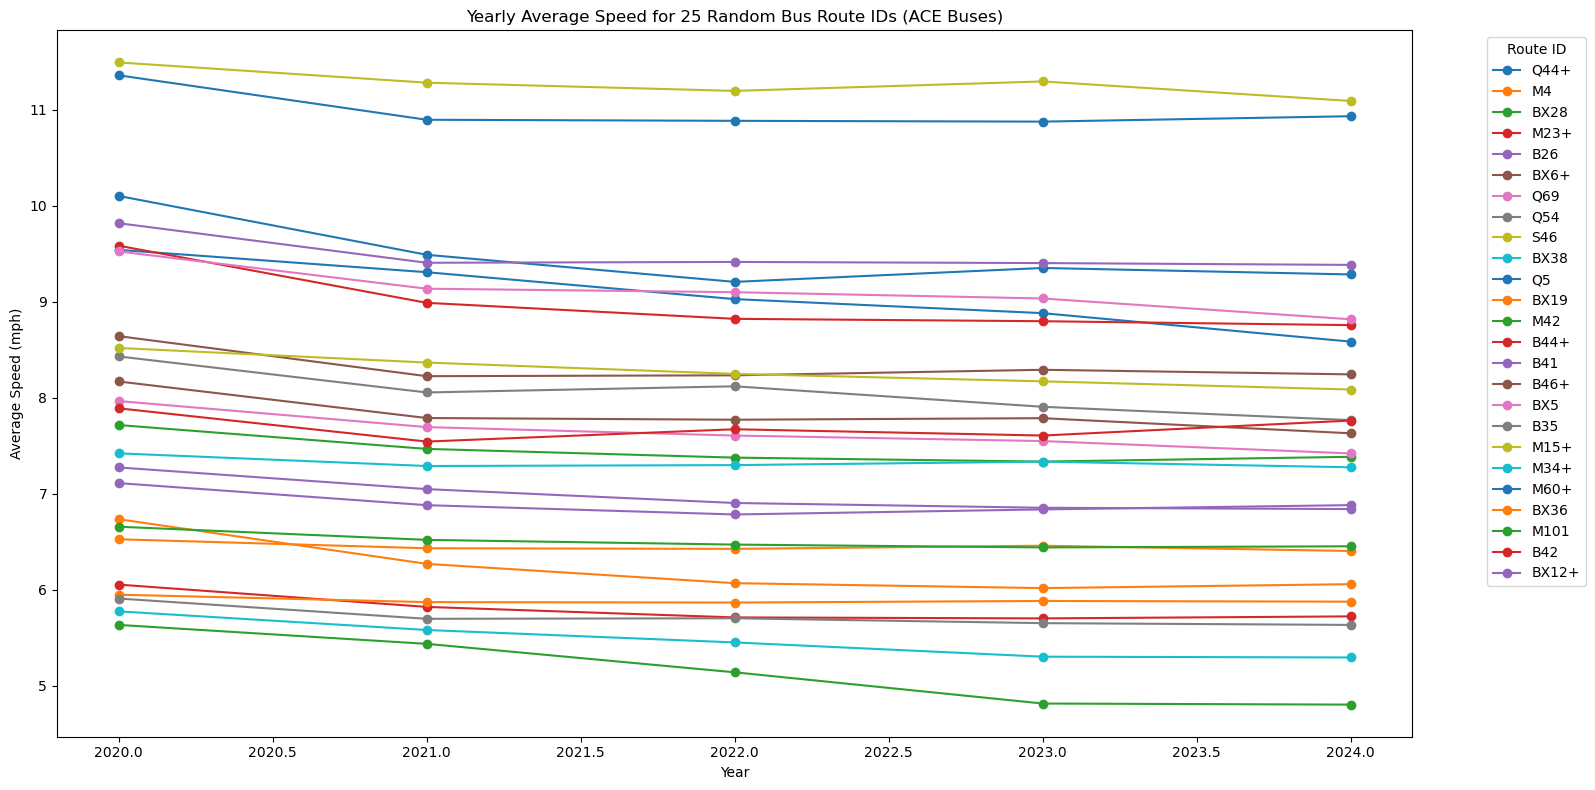

In [57]:
# Random 25 route_id and plot their average speed yearly, extracting year from month column
import random
# Ensure month column is datetime
if 'month' in ace_buses_speed.columns:
    ace_buses_speed['month'] = pd.to_datetime(ace_buses_speed['month'], errors='coerce')
    ace_buses_speed['year'] = ace_buses_speed['month'].dt.year
    # Get 25 random route_ids
    route_ids = ace_buses_speed['route_id'].dropna().unique()
    sample_routes = random.sample(list(route_ids), min(25, len(route_ids)))
    # Filter data for sampled routes
    sample_data = ace_buses_speed[ace_buses_speed['route_id'].isin(sample_routes)]
    # Group by route_id and year, calculate average speed
    avg_speed_yearly = sample_data.groupby(['route_id', 'year'], as_index=False)['average_speed'].mean()
    plt.figure(figsize=(16, 8))
    for route in sample_routes:
        route_data = avg_speed_yearly[avg_speed_yearly['route_id'] == route]
        plt.plot(route_data['year'], route_data['average_speed'], marker='o', label=str(route))
    plt.title('Yearly Average Speed for 25 Random Bus Route IDs (ACE Buses)')
    plt.xlabel('Year')
    plt.ylabel('Average Speed (mph)')
    plt.legend(title='Route ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.tight_layout()
    plt.show()
else:
    print("month column not found in ace_buses_speed.")

In [58]:
# ANOVA test: difference in yearly average speed for 25 random ACE bus routes (2020-2024)
from scipy.stats import f_oneway
anova_years = [2020, 2021, 2022, 2023, 2024]
anova_data = []
for year in anova_years:
    speeds = avg_speed_yearly[avg_speed_yearly['year'] == year]['average_speed'].dropna()
    anova_data.append(speeds)
if all(len(group) > 0 for group in anova_data):
    f_stat, p_value = f_oneway(*anova_data)
    print(f'ANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}')
    if p_value < 0.05:
        print('There is a significant difference in yearly average speeds among ACE bus routes (2020-2024).')
    else:
        print('No significant difference in yearly average speeds among ACE bus routes (2020-2024).')
else:
    print('Not all years have data for ANOVA test.')

ANOVA F-statistic: 0.301, p-value: 0.8765
No significant difference in yearly average speeds among ACE bus routes (2020-2024).


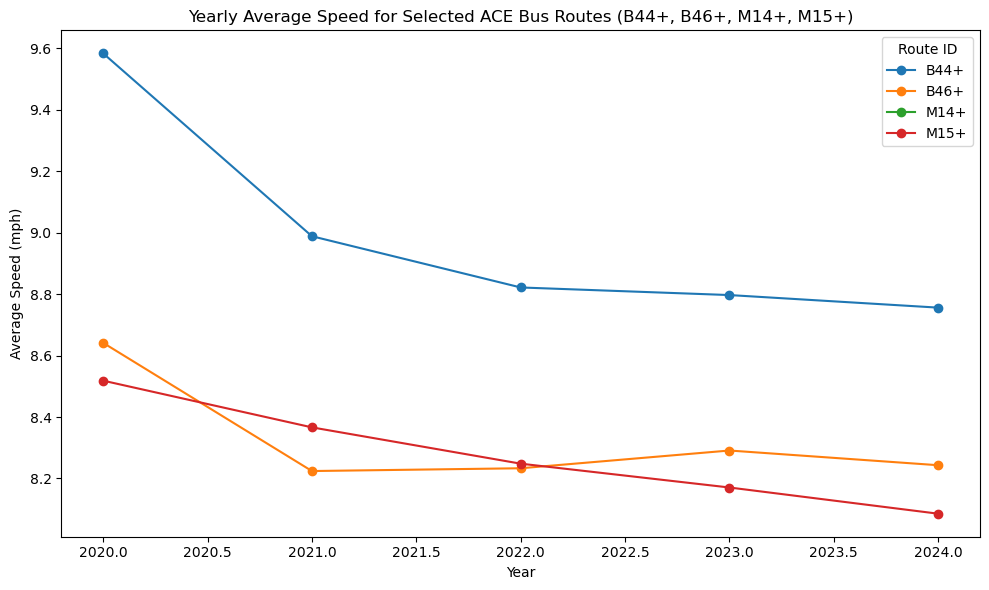

In [62]:
# Lineplot for yearly average speed of B44+, B46+, M14+, M15+ in ace_buses_speed
selected_routes = ['B44+', 'B46+', 'M14+', 'M15+']
if 'month' in ace_buses_speed.columns:
    ace_buses_speed['month'] = pd.to_datetime(ace_buses_speed['month'], errors='coerce')
    ace_buses_speed['year'] = ace_buses_speed['month'].dt.year
    filtered_data = ace_buses_speed[ace_buses_speed['route_id'].isin(selected_routes)]
    avg_speed_yearly = filtered_data.groupby(['route_id', 'year'], as_index=False)['average_speed'].mean()
    plt.figure(figsize=(10, 6))
    for route in selected_routes:
        route_data = avg_speed_yearly[avg_speed_yearly['route_id'] == route]
        plt.plot(route_data['year'], route_data['average_speed'], marker='o', label=route)
    plt.title('Yearly Average Speed for Selected ACE Bus Routes (B44+, B46+, M14+, M15+)')
    plt.xlabel('Year')
    plt.ylabel('Average Speed (mph)')
    plt.legend(title='Route ID')
    plt.tight_layout()
    plt.show()
else:
    print("month column not found in ace_buses_speed.")

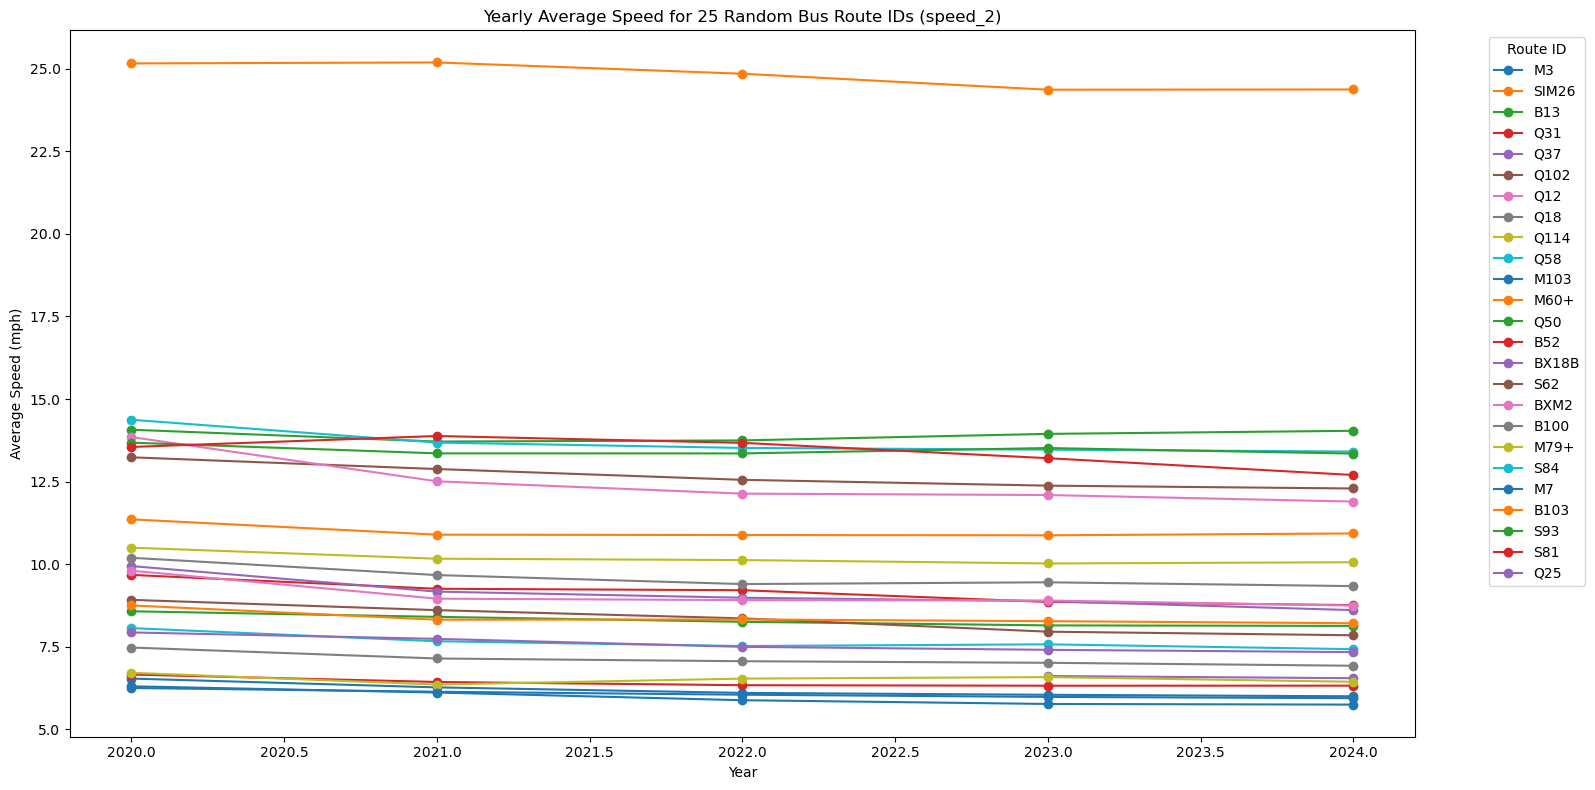

In [65]:
# Lineplot for yearly average speed of 25 random route_ids in speed_2
import random
if 'month' in speed_2.columns:
    speed_2['month'] = pd.to_datetime(speed_2['month'], errors='coerce')
    speed_2['year'] = speed_2['month'].dt.year
    route_ids = speed_2['route_id'].dropna().unique()
    sample_routes = random.sample(list(route_ids), min(25, len(route_ids)))
    sample_data = speed_2[speed_2['route_id'].isin(sample_routes)]
    avg_speed_yearly = sample_data.groupby(['route_id', 'year'], as_index=False)['average_speed'].mean()
    plt.figure(figsize=(16, 8))
    for route in sample_routes:
        route_data = avg_speed_yearly[avg_speed_yearly['route_id'] == route]
        plt.plot(route_data['year'], route_data['average_speed'], marker='o', label=str(route))
    plt.title('Yearly Average Speed for 25 Random Bus Route IDs (speed_2)')
    plt.xlabel('Year')
    plt.ylabel('Average Speed (mph)')
    plt.legend(title='Route ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.tight_layout()
    plt.show()
else:
    print("month column not found in speed_2.")

Top 5 route_id by average speed and their total violation counts:
Route: S79+, Total Violation Count: 6038371
Route: Q53+, Total Violation Count: 8814720
Route: S46, Total Violation Count: 9984720
Route: M60+, Total Violation Count: 23901626
Route: BX12+, Total Violation Count: 44044042


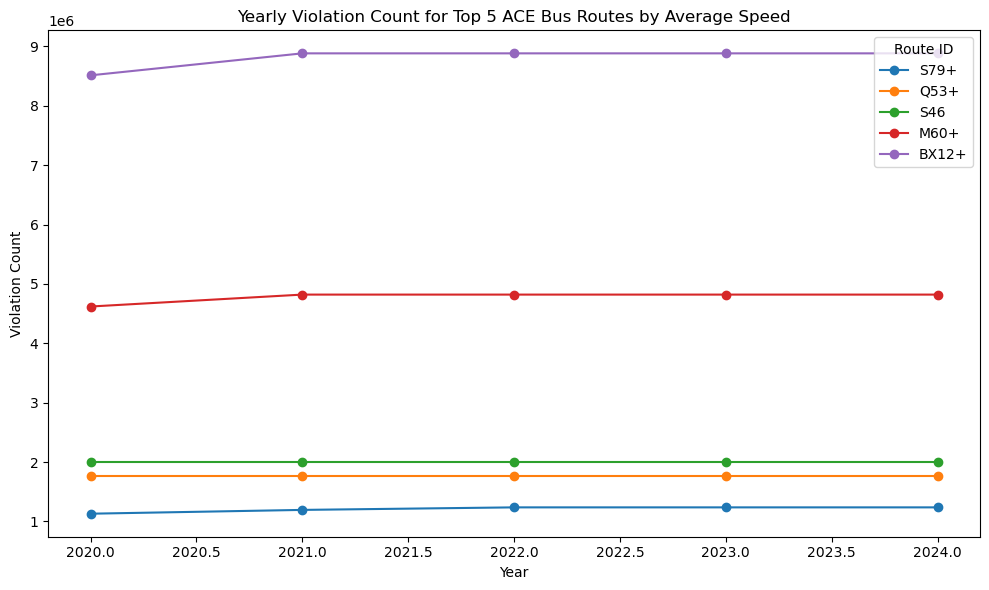

In [67]:
# Top 5 unique route_id in ace_buses_speed by average speed and their violation counts
if 'route_id' in ace_buses_speed.columns and 'average_speed' in ace_buses_speed.columns and 'Violation Count' in ace_buses_speed.columns and 'month' in ace_buses_speed.columns:
    ace_buses_speed['month'] = pd.to_datetime(ace_buses_speed['month'], errors='coerce')
    ace_buses_speed['year'] = ace_buses_speed['month'].dt.year
    avg_speed_per_route = ace_buses_speed.groupby('route_id', as_index=False)['average_speed'].mean()
    top5_routes = avg_speed_per_route.nlargest(5, 'average_speed')['route_id']
    top5_data = ace_buses_speed[ace_buses_speed['route_id'].isin(top5_routes)]
    # Print route_id and violation counts
    violation_counts = top5_data.groupby('route_id')['Violation Count'].sum()
    print('Top 5 route_id by average speed and their total violation counts:')
    for route in top5_routes:
        print(f'Route: {route}, Total Violation Count: {violation_counts.get(route, 0)}')
    # Plot violation count over year for each route
    yearly_vio = top5_data.groupby(['route_id', 'year'], as_index=False)['Violation Count'].sum()
    plt.figure(figsize=(10, 6))
    for route in top5_routes:
        route_data = yearly_vio[yearly_vio['route_id'] == route]
        plt.plot(route_data['year'], route_data['Violation Count'], marker='o', label=str(route))
    plt.title('Yearly Violation Count for Top 5 ACE Bus Routes by Average Speed')
    plt.xlabel('Year')
    plt.ylabel('Violation Count')
    plt.legend(title='Route ID')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found in ace_buses_speed.")

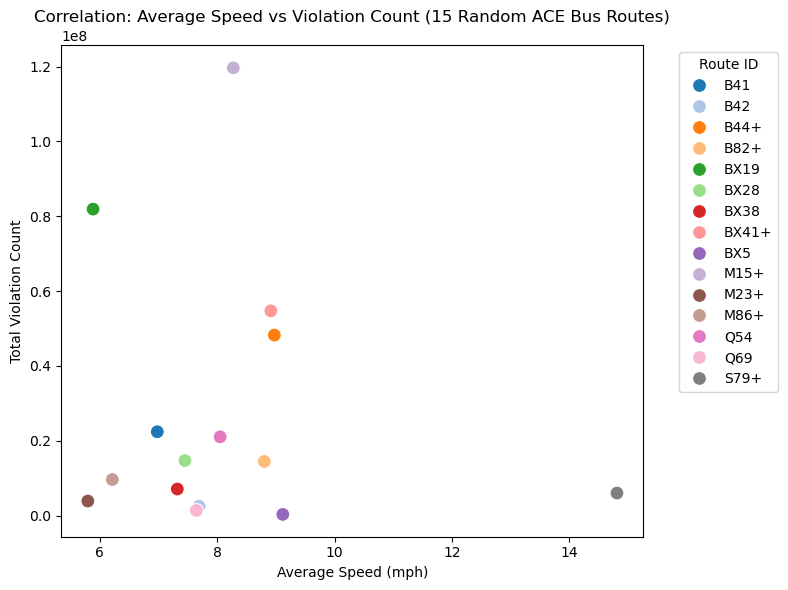

Pearson correlation coefficient: -0.100, p-value: 0.7219
No statistically significant correlation between average speed and violation count.


In [70]:
# Correlation plot for 15 random route_ids in ace_buses_speed: speed vs violation count
import random
if 'route_id' in ace_buses_speed.columns and 'average_speed' in ace_buses_speed.columns and 'Violation Count' in ace_buses_speed.columns:
    route_ids = ace_buses_speed['route_id'].dropna().unique()
    sample_routes = random.sample(list(route_ids), min(15, len(route_ids)))
    sample_data = ace_buses_speed[ace_buses_speed['route_id'].isin(sample_routes)]
    # Group by route_id, calculate mean speed and total violation count
    corr_data = sample_data.groupby('route_id', as_index=False).agg({'average_speed': 'mean', 'Violation Count': 'sum'})
    # Plot correlation scatterplot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=corr_data, x='average_speed', y='Violation Count', hue='route_id', palette='tab20', s=100)
    plt.title('Correlation: Average Speed vs Violation Count (15 Random ACE Bus Routes)')
    plt.xlabel('Average Speed (mph)')
    plt.ylabel('Total Violation Count')
    plt.legend(title='Route ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    # Statistical analysis: Pearson correlation
    from scipy.stats import pearsonr
    corr_coef, p_value = pearsonr(corr_data['average_speed'], corr_data['Violation Count'])
    print(f'Pearson correlation coefficient: {corr_coef:.3f}, p-value: {p_value:.4f}')
    if p_value < 0.05:
        print('There is a statistically significant correlation between average speed and violation count.')
    else:
        print('No statistically significant correlation between average speed and violation count.')
else:
    print("Required columns not found in ace_buses_speed.")